<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_04_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Training

In this Lab, we will introduce different topics related to the training phase of deep neural networks,  including data augmentation, optimization/regularization techniques, weight initializations, loss function and hyperparameters tuning.


## objectives 
- we want to understand 
    - regularization and its effect 
    - the importance of initialization 
    - and so on

## Preliminary

Here, we load the MNIST dataset and define a model for digit classification by using our own method `get_data_model`. We also define a new function `plot_history`, which plots the training loss and if required the validation loss. 

In [2]:
import numpy as np
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.utils import to_categorical #used to convert labels from numbers to one-hot encoded vectors
import matplotlib.pyplot as plt 
from keras.datasets import mnist
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

# takes a metric (accuracy or loss or ...) and plot it for validation and train sets
# we will see later a better way to do so
def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

# take the data of mnist, process it and defines model then return both the data and the model 
def get_data_model(args = {}): # args is a dictionary of additional parameters we may put in the layer below 
  
  # Returns simple model, flattened MNIST data and categorical labels
  num_classes=10
  #
  # xtrain (m_samples * width * height)
  # the data, shuffled and split between train and test sets
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
  # flatten out the images
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2]) # xtrain will be (m_samples, width * height) we flattened the pattern from 2d to 1d
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

  # make sure we are working on floats 
  x_train= x_train.astype('float32')
  x_test= x_test.astype('float32')

  # normalize by dividing by the maximum
  x_train /= 255
  x_test /= 255
  

  # to make the labels one hot encoded
  y_train=to_categorical(y_train,num_classes)
  y_test=to_categorical(y_test,num_classes)

  # Load simple model
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=(784,), **args)) #because each image was 28*28 and we flattened it out to be 784, preferrable to be hardcoded
  model.add(Dense(512, activation='relu', **args)) # **args is a synatx that adds the additional arguments automatically :)
  model.add(Dense(10, activation='softmax', **args))
  return model, x_train, y_train, x_test, y_test

model, x_train, y_train, x_test, y_test = get_data_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


- sometimes we say we do not want to train all the parameters (we maybe exclude the first 2 layers for examples from training and so on)
    - these will be called non-trainable parameters
    - we will see later why we do that

In [2]:
to_categorical(8,num_classes=10)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [3]:
y_train.shape

(60000, 10)

## Optimizers

Once the model has been created, it is necessary to define an optimizer. In a deep learning problem, optimizers take in each time-step the gradient of the loss function respect to the weights of the network. Then, the weights are updated to minimize the loss value. Different optimizers follow different rules for updating the weights. For example, the vanilla Stochastic Gradient Descent (SGD) only uses the gradient in the current time-step $t$ and the learning rate to update the weights. 

Since there are methods more prone to get stuck in local minima and other methods converging faster, the choice of the optimizer can potentially affect both the final performance and the speed of convergence.  A nice visualization of such behavior is the following animation, where you can notice some methods, i.e., Adadelta in yellow, and Rmsprop in black converge significantly faster than SGD in red failing in local minima. 

![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

The animation above is from [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/), who wrote an interesting article about the math formulation and properties of different optimizers. In this tutorial, we will follow a hands-on approach and will mainly focus on how to use them in Keras. 


As a rule of thumb, Adam is usually easier to tune due to the adaptive learning rate, whereas SGD with momentum [has been shown](https://arxiv.org/pdf/1712.07628.pdf) to reach better results when tuned correctly. Consult the official documentation [Optimizers in Keras](https://keras.io/optimizers/) to see the available implemented optimizers in Keras.

When defining a model in Keras we need to call the `compile` method, which  requires two arguments in string format: a loss function and an optimizer. For example, in the next piece of code we use as optimizer Adam, which is an widely used optimizer, and as our loss function the categorical cross-entropy.

- theoritically people prefer Adam optimizer (rmsprop + momentum)
- but practically keep an eye on **SGD**, even though it is the simplest yet it is very robust 

In [4]:
# in compilation loss we define the loss and the optimizer 
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(x_train,y_train,batch_size=128, epochs=10, verbose=1,validation_data=(x_test,y_test)) # batch size is convensionally multiples of 2

Epoch 1/10
469/469 [==============================] - 12s 24ms/step - loss: 0.2164 - val_loss: 0.1044
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0802 - val_loss: 0.0829
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0530 - val_loss: 0.0809
Epoch 4/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0367 - val_loss: 0.0716
Epoch 5/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0273 - val_loss: 0.0710
Epoch 6/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0215 - val_loss: 0.0707
Epoch 7/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0185 - val_loss: 0.0852
Epoch 8/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0186 - val_loss: 0.0741
Epoch 9/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0137 - val_loss: 0.0845
Epoch 10/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0125 - val

- when we pass the test set or cv set to the model..fit() it only use them to calculate the loss on them (no training included!!) and it does that after each epoch
    - it does not tune any hyper parameters anything (we do that when we train different models with different values for the hyperparameter)

## Initializers (initializing the weights)


Neural Networks have a large number of weights that we need to initialize before starting training. Weight initialization is a crucial step in tuning neural networks as different initial values can lead the model to reach different local minima. The weights are usually randomly initialized by different algorithms, e.g. Xavier,  He_normal, LeCun. 

In Keras, you can set the particular initialization strategy you want to use as an argument when declaring a layer. For example, in the function `Dense()` which defines the mapping $y= Ax + b$, you can initialize the kernel values ($A$ in the equation) with a normal distribution (by default the `stddev` is 0.05) and the bias ($b$ in the equation) with $0$ using the code below.

there is research going on how to initialize the parameters (the Ws, as the Bs are initialized with zeros)
- **random_normal** : initialize from normal distribution (gaussian distribution) (bell shape)
- **He_normal** : also sampled from normal distribution (but truncated) meaning we do not take from the whole gaussian distriution that goes from -inf to inf 
    - like sampling from a normal distribution between -1 and 1 or something else
- **Xavier** : we initialize with normal distribution then divide by sqrt(number of nodes in the previous layer (input) + number of nodes in our layer (output) ) -there are other extensions to it - ......... and it has some interesting properties
    - it does not make the variance high in our NN 
    
- **practically people are interested in xavier initializer** which is the default anyway 

In [11]:
linear_layer = Dense(64, kernel_initializer='random_normal',
                bias_initializer='zeros')

Now let's check the weights of the layers and see if they follow the distributions we set. 

In [14]:
# we make a vector of size (1,64) sampled from normal dist. and we pass it as an input to the to a linear layer with parameters sampled from normal distribution
from keras.layers import Input
import numpy as np
from keras import backend as K
input_x = K.variable(np.random.random((1, 64)))
y = linear_layer(input_x) 
weights = linear_layer.get_weights()
# Weights return an array with [kernel(Ws) some people call the weights by kernel, bias]
# Let's see the kernel weights
print(weights[0])

[[ 0.00461134 -0.02924305  0.09152124 ...  0.00480258 -0.00213413
   0.00882547]
 [ 0.07421652 -0.00120645 -0.0528614  ...  0.1073707   0.01692697
  -0.01314939]
 [ 0.01644756 -0.03612712  0.11724919 ...  0.07798634 -0.01269603
  -0.02749326]
 ...
 [-0.02666024 -0.03199873 -0.0789887  ... -0.04495497  0.04753818
   0.02551466]
 [-0.02255632 -0.03317323  0.01326815 ...  0.05309626 -0.12053851
  -0.01760302]
 [ 0.00362567  0.01006119 -0.04032537 ... -0.02994352 -0.00373103
   0.05862116]]


In [12]:
np.random.random((1,64))

array([[0.16931586, 0.40244614, 0.70270537, 0.00752923, 0.74936764,
        0.97559166, 0.87446034, 0.75104613, 0.5102567 , 0.7526509 ,
        0.46422759, 0.00306445, 0.49660066, 0.3572326 , 0.15582323,
        0.231351  , 0.19637031, 0.3254057 , 0.82621522, 0.4405695 ,
        0.53977568, 0.19240163, 0.16341009, 0.1148145 , 0.30722092,
        0.84192598, 0.81811764, 0.53329762, 0.71315922, 0.34419571,
        0.88902433, 0.78904914, 0.3592599 , 0.59579563, 0.0419652 ,
        0.0922522 , 0.14808096, 0.0761339 , 0.25395881, 0.1825156 ,
        0.48553011, 0.30353597, 0.3122908 , 0.45387503, 0.87089096,
        0.56354355, 0.03168781, 0.25499939, 0.11415761, 0.79334529,
        0.11326584, 0.81714564, 0.01057891, 0.33388345, 0.4777138 ,
        0.34021747, 0.74573015, 0.68536135, 0.75844893, 0.93850379,
        0.62903817, 0.22053296, 0.69725612, 0.82565281]])

In [15]:
K.variable(np.random.random((1,64)))

<tf.Variable 'Variable:0' shape=(1, 64) dtype=float32, numpy=
array([[0.34080812, 0.45122728, 0.41667938, 0.7699937 , 0.996254  ,
        0.76272315, 0.38021252, 0.8166104 , 0.3751056 , 0.6744306 ,
        0.12699233, 0.6284528 , 0.96630263, 0.9068863 , 0.07168487,
        0.9289938 , 0.98347306, 0.9655205 , 0.23215982, 0.35901892,
        0.76015705, 0.73938674, 0.7343255 , 0.19233052, 0.7050007 ,
        0.18105365, 0.40029365, 0.23656973, 0.52191925, 0.2914526 ,
        0.19812313, 0.95675915, 0.9930963 , 0.8916228 , 0.14625692,
        0.5621438 , 0.5350925 , 0.81241375, 0.56028646, 0.32230338,
        0.8897862 , 0.9639381 , 0.36540267, 0.6006719 , 0.75015604,
        0.81198853, 0.18578203, 0.8471299 , 0.3883523 , 0.76625246,
        0.2989974 , 0.86872286, 0.27576083, 0.7245162 , 0.5468991 ,
        0.11054132, 0.05731757, 0.270385  , 0.4474656 , 0.11726219,
        0.33290228, 0.9066322 , 0.25919923, 0.00502319]], dtype=float32)>

In [20]:
# mine: we can do that (the weights initialization doesnt depent on the input range)
x = np.random.randint(0,100,size=(1,64))
linear_layer = Dense(64, kernel_initializer='random_normal',
                bias_initializer='zeros')
linear_layer.get_weights()
linear_layer(x)
linear_layer.get_weights()

[array([[ 0.03572235,  0.00552255,  0.05513495, ...,  0.0568811 ,
          0.02562272,  0.04398557],
        [ 0.00559715, -0.04734423,  0.05359516, ...,  0.10713089,
         -0.00879694,  0.06578738],
        [-0.03370197,  0.0055841 ,  0.02226854, ...,  0.12784098,
         -0.04624938,  0.06834371],
        ...,
        [ 0.04107102, -0.01937935,  0.01928372, ..., -0.0326111 ,
         -0.03820933, -0.06542736],
        [-0.03691563, -0.00775335, -0.03367172, ..., -0.11723006,
         -0.03895398,  0.05215282],
        [ 0.04169411,  0.03812246,  0.03314653, ...,  0.02709167,
         -0.00441526, -0.01783091]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [21]:
# Now let's check that the mean is 0 and stddev is around 0.05
print(weights[0].mean(), weights[0].std())

0.00032163726 0.050110076


In [22]:
# Let's print the bias now
print(weights[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The number of initializations available in Keras is listed [in the documentation](https://keras.io/initializers/). By default in Keras the kernel weights are initialized as `'glorot_uniform'` and the bias to `'zeros'`. Glorot uniform, which is also called Xavier initialization was defined [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). It samples the weights from a uniform distribution, whose range depends on the number of input and output units. Another initializer quite used is the `he_normal`, which draws the weights from a truncated normal distribution.

## Loss functions (regarding 2 tasks: classification and regression)

Another important step in training deep neural networks is the choice of the loss function, which strictly depends on your problem. In this tutorial, we will introduce two typical losses i.e., cross entropy and mean squared error, for two standard problems in machine learning: classification and regression. The full list of standard losses in Keras is available [here](https://keras.io/losses/).

- classification 
    - binary classification problem (y takes only 2 values)
        - loss: binary cross entropy 
        - final layer activation: sigmoid
        - final layer neurons: only 1
    - multiclass classification problem (y takes a value out of n values n > 2)
        - loss = categorical cross entropy (y hot encoded) or sparse categorical cross entropy (y is decimal value)
        - final layer activation: softmax
        - final layer neurons: n neurons 
- regression problems (y takes a value in continous range) like price or angel of robotics 
- we can't make the neurons of the final layer **too large** and do classification 
    - loss: L2 loss (sum of squared errors)
    - final layer activation: linear 
    - final layer neurons: only **1** if we want to predict only one value (y is scalar)

### Classification

For classification problems, the standard loss used is the cross-entropy loss. For the binary case, the formula is $\mathcal{L} = y\log(p) + (1-y)\log(1-p)$, where $p$ (yhat) is a probability value between $[0, 1]$.
To constrain the activations to assume (produce) such values, typically a [Sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function) is applied. In Keras, the presented binary classification loss is called `binary_crossentropy`, and it accepts as target a vector with an element in the range $[0, 1]$ (usually either $0$ or $1$) per input element.

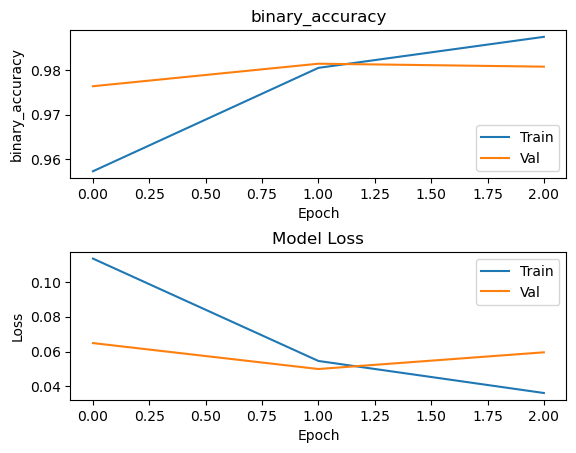

In [23]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.pop() # removes the last layer in the model, because it was 10 nodes softmax
model.add(Dense(1, activation='sigmoid'))


# we will make the y binary
# we will change the y to suit binary classification model, it it either > 5 or smaller than 5
# This three lines transform the problem in a binary one
# We want to know if the number is bigger than 5 (label 1) or smaller (label 0)
y_train = np.argmax(y_train, axis = 1) # this is the inverse of one-hot encoding
y_train[y_train < 5] = 0
y_train[y_train >= 5] = 1


model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['binary_accuracy'])
# notice that model.fit() returns the logs if we pass the return value to a variable
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
# history keeps the logs of (train acc,train loss, valodation acc,validation loss) after each epock
plot_history(history, 'binary_accuracy')

- notice that in the first epoch, the loss on validation is **lower** than train loss (alternatively the validation accuracy is **higher** than the train at first) **how? and why?**
- it is not a coincidence, but a common pattern 
- that is because in the very first epoch, the model parameters are randomly initialized and the train loss is exposed to them (that's why it is high since the parameters are yet to be adjusted) then we calculate the validation loss after the 1st epoch is done training 
- later since the weights are adusted to the train data we see the train accuracy goes up very fast and the train loss goes down very fast (more than the validation's)

In case the number of classes is higher than 2, we use the cross-entropy loss, which has the form of $\mathcal{L} = -\sum_i y_i\log(p_i)$. The loss is called `categorical_crossentropy` in Keras, and accepts one-hot encoded vectors. A one-hot encoded vector has dimensionality $C$, where $C$ is the number of classes. All of the elements are set to 0, minus the corresponding class $c$, which is set to 1. If we have a vector of labels with a scalar from $[0, C)$ per training example, we can transform it into a one-hot encoding form by using the function `to_categorical`.  

Let's see an example using MNIST data.

In [25]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# The labels are an scalar from 0 to 9 per example
print(y_train[:5])

[5 0 4 1 9]


In [26]:
keras.utils.to_categorical(y_train[:5])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

The output vector y-hat needs to be $\sum_i p_i = 1$, and we achieve that by applying the softmax activation function to the output vector.

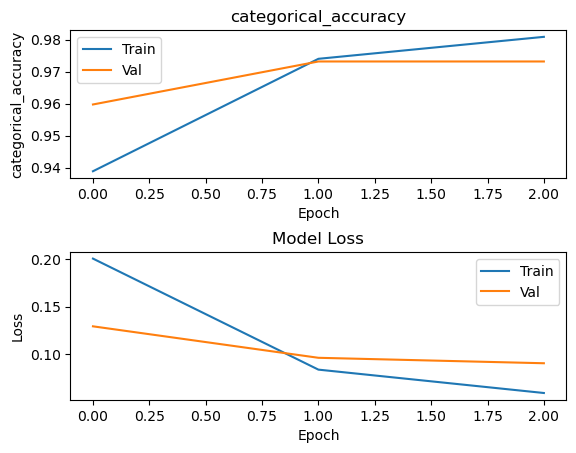

In [27]:
# We use the function get_data_model, which already applies to_categorical
_, x_train, y_train, x_test, y_test = get_data_model() #notice that we neglected the returned model

### Model defined with softmax
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'categorical_accuracy')

- when we define the **metrics** in model.compile(), we tell the model what metric are we interested in tracking it (just track their values -will be included in history-, it doesn't matter in optmization as we only optimize the loss function apart from what metric we are interested in)
    - don't mix it up with the loss function which tells the optimizer which function we want to optimize
- in summary we optimize on the loss function not the metrics
- **validation split** in keras, it takes some of the data randomly and use them as cross validation set 
- setting verbose to 0 prevent the model from printing any logs (we can already take them as a return from model.fit() )

In [32]:
history.history

{'loss': [0.20035205781459808, 0.08366229385137558, 0.05910537391901016],
 'categorical_accuracy': [0.9389166831970215,
  0.9739999771118164,
  0.9808541536331177],
 'val_loss': [0.1291760802268982, 0.09610484540462494, 0.090378038585186],
 'val_categorical_accuracy': [0.9597499966621399,
  0.9731666445732117,
  0.9731666445732117]}

- notice that it tracked the categorical_accuracy as we defined, plus to the loss (which is default and always get tracked) for both train and validation sets
- notice that each metric has 3 records because we only trained 3 epochs 

### Regression
For regression problems it is quite standard to use as losses the Mean Squared Error (MSE) or Mean Absolute Error (MAE), depending on the problem. 

As in the evaluation measures exercise, we will load the Boston Housing dataset.

In [28]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(y_train[:10]) # print the first 10 labels in the training data

57026/57026 [==============================] - 0s 2us/step
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


We see that the labels are float numbers (regression), and our goal is to predict them. To do so, we need a network that has only one output. Now, we will train the network using MAE (mean absolute error) takes the absolute of the difference **norm 1 or L1 loss** and MSE (mean squared error) takes the squared of the difference **norm 2 or L2 loss**. 

In [29]:
x_train.shape

(404, 13)

In [34]:
model_mae = Sequential()
model_mae.add(Dense(100, activation='relu', input_shape=(13,)))
model_mae.add(Dense(1)) #activation is linear by default 
model_mae.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mae.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

- notice that in the above model **we specified the loss to be mean absolute error** which means it will be optimized, but **in metrics** we said that we are interested to track both mean absolute error and mean squared error

In [35]:
history.history

{'loss': [23.824180603027344,
  12.416520118713379,
  9.068264961242676,
  7.8874592781066895,
  6.387304306030273,
  5.128575801849365,
  4.846848011016846,
  4.751585483551025,
  4.360195636749268,
  4.250219345092773,
  4.345024585723877,
  5.276858329772949,
  4.608630657196045,
  4.598427772521973,
  4.848541259765625,
  4.245826244354248,
  4.329266548156738,
  4.202284336090088,
  4.093021392822266,
  4.25421142578125,
  5.094013214111328,
  5.722812652587891,
  4.9903244972229,
  4.894515037536621,
  4.160680294036865,
  4.072300434112549,
  4.028816223144531,
  4.144787311553955,
  3.8578131198883057,
  4.435638904571533,
  4.065560340881348,
  3.8457391262054443,
  3.8486664295196533,
  3.9028780460357666,
  3.871429681777954,
  3.7941253185272217,
  3.797344446182251,
  3.831833600997925,
  3.7595603466033936,
  3.7326345443725586,
  4.291793346405029,
  3.98856782913208,
  4.438543796539307,
  3.813586473464966,
  3.8284661769866943,
  3.7723593711853027,
  3.90052556991577

- notice that in addition to tracking the loss, it also tracked mean absolute error (which is optimized here too) and mean squared error 
    - and since we specified a validation set, it will also calculagte all of them on the validation set as well as the train

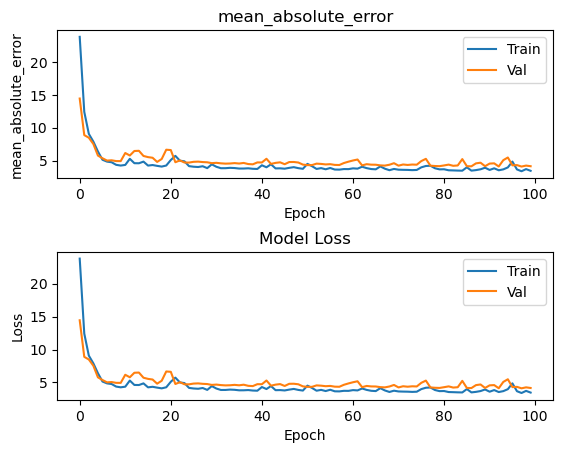

In [36]:
plot_history(history, 'mean_absolute_error')

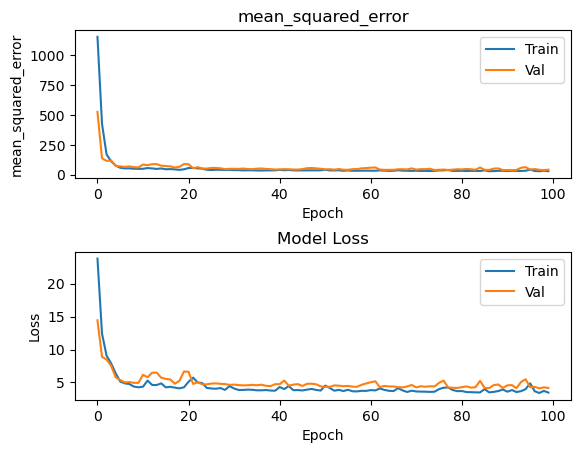

In [37]:
plot_history(history, 'mean_squared_error')

In [38]:
model_mse = Sequential()
model_mse.add(Dense(100, activation='relu', input_shape=(13,)))
model_mse.add(Dense(1))
model_mse.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mse.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

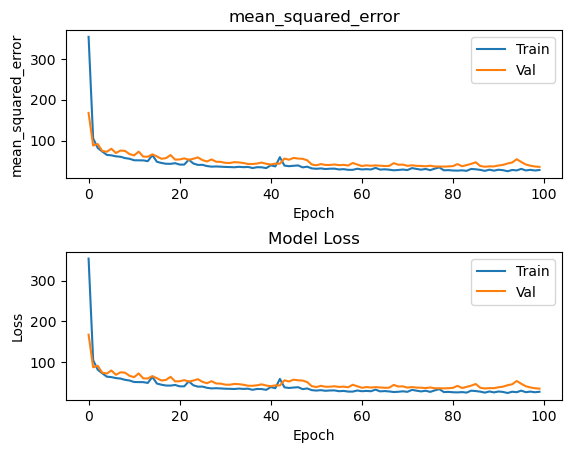

In [39]:
plot_history(history, 'mean_squared_error')

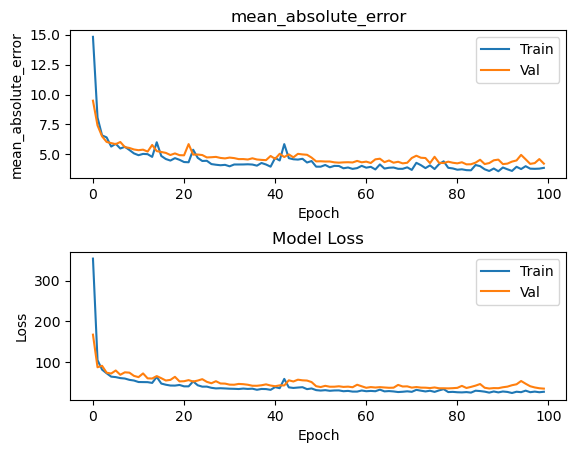

In [40]:
plot_history(history, 'mean_absolute_error')

- people prefer mean squared error because 
    - it is more differentiable than the absolute values 
    - it has more tendancy to get better accuracies (of course, no mathematical proofs)

### test them on the test set
- model.evaluate will **check the loss** against the given set (test set usually) and **also checks all the other metrics we specified** 

In [41]:
results = model_mae.evaluate(x_test, y_test)
print('MAE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

4/4 [==============================] - 0s 5ms/step - loss: 3.8602 - mean_absolute_error: 3.8602 - mean_squared_error: 35.9781
MAE trained model achieves MAE: 3.8602 and MSE: 35.9781


notice that since the model optimized MAE, it is lower than MSE

In [45]:
results = model_mse.evaluate(x_test, y_test)
print('MSE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

4/4 [==============================] - 0s 4ms/step - loss: 30.4347 - mean_absolute_error: 4.0851 - mean_squared_error: 30.4347
MSE trained model achieves MAE: 4.0851 and MSE: 30.4347


- notice that since the model optimized MSE rather than MAE, the MSE is lower here than the previous model (and the previous model has lower MAE than here)
- notice that the MAE model here has better loss than the the MSE (even though we said earlier the opposite is likely to happen)

The plots show that training using MSE as loss achieves a better MSE and worse MAE in the test set compared to the model training with MAE loss.

Now let's print some predicted prices from the test set, along with the actual price, just to have an intuition of the output values.

In [50]:
pred_prices = model_mae.predict(x_test) # we printed some predictions of the better model and compared them with the ground truth labels 
print("predicted values: " + str(np.around(pred_prices[:10, 0], 2)) )
print("actual values: " + str(y_test[:10]))

4/4 [==============================] - 0s 3ms/step
predicted values: [ 6.12 20.54 21.31 24.13 23.31 21.27 26.1  23.   19.88 18.13]
actual values: [ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


A problem usually treated as a regression problem with deep learning approaches is depth estimation, where the depth of an image is estimated using the RGB information. Some other regression losses are also used in some settings (e.g. Huber loss or Reverse Huber loss, or the already introduced Mean Percentage Absolute Error), but MAE and MSE are the most widely used. 

## Regularization (to prevent overfitting if it does)
As mentioned in the lecture, regularization is an effective tool to fight some of the problems we may have during training, such as vanishing/exploding gradients or overfitting to the training set. We now mention some of the usual ways to regularize our training process. 

### Loss regularizers

[Regularizers](https://keras.io/regularizers/)  put some penalties to the optimization process. In practice by penalizing large values, weights are constrained to be small which can help us prevent overfitting.

In Keras regularization works on a per-layer basis. It means you can define a regularization function for each layer. In particular,  you can specify three regularization parameters each one related to a different type of penalty:

*   `kernel_regularizer`: a penalty depending on the value of the kernel weights, e.g, larger kernel weights result in larger penalization.
*   `bias_regularizer`: a penalty depending on the loss function is applied to the value of the bias. If you want the output function to pass through (or have an intercept closer to) the origin, you can use the `bias_regularizer`.
*   `activity_regularizer`: a penalty applied to the loss function depending on the layer's output. It results in smaller outputs in value when this regularizer is applied.

Standard regularizers that can be applied are $l_1$, $l_2$ and $l_1+l_2$. 
In the example below, we check the difference in training and validation accuracy by varying the used regularization strategy.


- we have 3 types of regulariation 
    - **kernel regularizer**:regularizes the weights (Ws) remember that some people call the Ws kernel
        - tries to make the Ws small (the smaller the Ws the better the loss)
        - helps in preventing overfitting 
    - **bias regularizer**: regularizes the biases
        - tries to make the biases small (the smaller the biases the better the loss)
        - helps in preventing overfitting
    - **activity regularizer**: works on the output of the layer 
        - tries to make the output small (the smaller the output the better the loss)
        - we do that because some activation functions like tanh and sigmoid have high derivatives with large inputs 
        - helps in preventing exploding gradients and divergence 
        - practically it is BARELY used (propably not at all)

Training with regularization value of 0.001000
313/313 [==============================] - 2s 6ms/step - loss: 0.2132 - accuracy: 0.9774
Training with regularization value of 0.000300
313/313 [==============================] - 2s 5ms/step - loss: 0.1354 - accuracy: 0.9823
Training with regularization value of 0.000100
313/313 [==============================] - 2s 6ms/step - loss: 0.1084 - accuracy: 0.9812
Training with regularization value of 0.000030
313/313 [==============================] - 2s 6ms/step - loss: 0.0960 - accuracy: 0.9805
Training with regularization value of 0.000010
313/313 [==============================] - 2s 6ms/step - loss: 0.0991 - accuracy: 0.9786
Training with regularization value of 0.000003
313/313 [==============================] - 2s 6ms/step - loss: 0.0850 - accuracy: 0.9801
Training with regularization value of 0.000001
313/313 [==============================] - 2s 6ms/step - loss: 0.1032 - accuracy: 0.9760


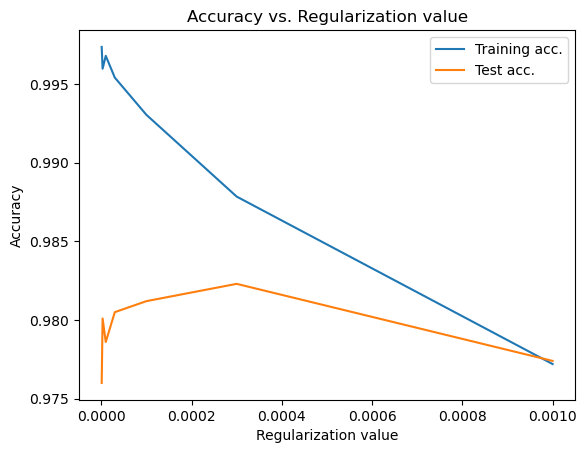

In [52]:
# we will only try regularizing the Ws
from keras import regularizers
test_accuracy = []
train_accuracy = []
# in practice we commonly try the first 3 values below, notice that they are small as 0.01 is HUGE LAMBDA which probably would lead to learning nothing (underfitting) 
reg_values = [0.001, 0.0003, 0.0001, 0.00003, 0.00001, 0.000003, 0.000001] #lambdas
# notice that we have tendency to lower by dividing by 3 0.001 / 3 >> 0.0003333 and so on
 

for reg_val in reg_values: 
  print('Training with regularization value of {:f}'.format(reg_val))
  args_dict = {'kernel_regularizer': regularizers.l2(reg_val)} # this is the args dict we talked about in the first function (will be passed in as additional parameters using **args)
# we use the args dict to pass a parameter inside a function which is inside the function that will take argdict 
  model, x_train, y_train, x_test, y_test = get_data_model(args_dict)
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=10, batch_size=256, verbose=0)
  train_accuracy.append(history.history['accuracy'][-1])
  test_accuracy.append(model.evaluate(x_test, y_test)[-1])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(reg_values, train_accuracy)
plt.plot(reg_values, test_accuracy)
plt.legend(['Training acc.', 'Test acc.'])
plt.title('Accuracy vs. Regularization value')
plt.ylabel('Accuracy')
plt.xlabel('Regularization value')
plt.show()
  

In this example, regularizing the weights actually dropped the final accuracy, although we see how the gap between training and test accuracy decreases. 

- as we said, after the first 3 values, the accuracy started to decrease 
- mine: we may say that the optimal labmda value is half way between 0.0002 and 0.0004

### Dropout

Dropout is another regularization technique that can be applied. A Dropout layer deactivates during training some weights of the model by setting elements to 0 with a certain probability. The dropout value, i.e., the probability of disabling the input units, can be set as a parameter when defining a layer. In the evaluation phase, all of the weights are activated and dropout does not have any effect on the model. The dropout layer also scales during training the non-zero elements by 1/(1-prob_drop) (the TA said we divide by the prob_drop itself) to maintain a similar norm between training and evaluation. 

For example, in the following layer, the dropout value is 0.3, meaning 30% of the input data is switched off during training.

In [53]:
prob_drop = 0.3
drop = keras.layers.Dropout(prob_drop)

In [4]:
# here we just import a separate droupout layer and see some input before and after passing on it (to see its effect)

from keras.layers import Dropout
import numpy as np
from keras import backend as K
x = np.random.random((1, 512))
input_x = K.variable(x)
# Set learning phase is used to manually setting
# the phase (0 evaluation, 1 training)
# Dropout only affects training, so we set it to 1 
# we said that the model has 2 phases, that's how the model knows whenever to dropout (training) or not (testing)
K.set_learning_phase(1)
y = K.eval(drop(input_x))
print('Input (10 elements)')
print(x[0,0:10])
print('Output (10 elements)')
print(y[0,0:10])

NameError: name 'drop' is not defined

In [56]:
print(x.mean(),y.mean())

0.4943575336219364 0.5133538


We now check what percentage of elements have been set to 0, and what is the scaling value the other elements have.

- we notice that with each run different elements are set to 0 with the percentage of 30% as we specified
- we also notice that the rest of the elements are scaled to have similar average as the testing later would have 
    - we see above that they have similar average before and after the droupout, so that it does't affect the testing performance as it would have a different average (similar to the training data average before droping out)

In [63]:
print('Drop percentage, should be close to {:f}'.format(prob_drop))
print(((y==0).sum())/(1.0*y.shape[1]))

# scaling value should be 1/0.3 (the opposite of 30%)
print('Scaling value, should be {:f}'.format(1/(1-prob_drop)))
print(((y[y!=0]).sum())/(1.0*x[y!=0].sum()))


Drop percentage, should be close to 0.300000
0.279296875
Scaling value, should be 1.428571
1.4285714322300076


### Batch Normalization

Batch Normalization computes the mean and the standard deviation per channel, i.e. given a feature map of dimensionality $B\times H\times W\times C$ ($B$ is batch size, $H,W$ spatial dimensions and $C$ number of feature channels) the layer computes the mean $\mu$ and standard deviation $\sigma$, where $\mu$ and $\sigma$ have dimensionality $1\times 1\times 1\times C$. Then, the mean $\mu$ and the standard deviation $\sigma$ of the batch are used to standardize all of the dimensions of the input feature to follow a distribution with mean 0 and variance 1.
The layer is defined in Keras by using:

In [90]:
batch_norm = keras.layers.BatchNormalization(axis=-1, input_shape=[10,10,1])

Now we will generate a batch of 512x1 (a batch of 512 vectors of only 1 channel) using `np.random.random`, which is a uniform distribution under the $[0, 1)$ interval, resulting in mean 0.5 and variance 1/12. Finally, the batch normalization layer scales the distribution to have mean 0 and variance 1.



In [100]:
from keras.layers import BatchNormalization
import numpy as np
from keras import backend as K
K.set_learning_phase(1) # means we are in training 
x = np.random.random((512, 10, 10, 1)) # we get numbers with mean = 0.5 and std close to  or something 
input_x = K.variable(x) # make our input a variable in keras 
y = K.eval(batch_norm(input_x)) # do batch normalization on it 
print('Input')
print(x[:10, 0, 0, 0])
print('Output')
print(y[:10, 0, 0, 0])

Input
[0.85747474 0.52850206 0.36608114 0.35746131 0.98531487 0.02703885
 0.62942414 0.16192664 0.64804902 0.53929811]
Output
[ 1.2320187   0.10046692 -0.4582045  -0.4878538   1.6717442  -1.6243923
  0.44760388 -1.1604251   0.5116669   0.13760164]


- notice that the output is kind of pre-processed (standarilized)

In [101]:
# Input mean should be ~0.5 and var ~1/12=0.0833
print(x.mean(), x.var())
# Output mean should be ~0 and var ~1
print(y.mean(), y.var())

0.4992938193470247 0.08352257706124673
7.707533e-07 0.988173


meaning that whatever was before the layer, we passed it to the batch normalization error and normalized it (made the mean close to 0 and the std close to 1)

Batch normalization changes behaviour in evaluation mode. During training the layer also tracks the moving average of both mean and variance, which are then used to normalize the testing data without having to use the statistics from the testing batch.

- don't forget that the **mean and the standard deviation** which the **batch normalization layer** divide by **are learnable parameters added to the NN**

## HyperParameters Tuning

When training our model, we need to decide the value of several hyperparameters, what regularization techniques we employ, or the loss used to train the model, among others. To decide these values we should not use as guidance the performance in the test set, as it may lead to overfitting to that set, and in turn to an erroneous estimate of the performance of the model in non-seen data. Hence, we use what is called a validation set, which we use to tweak the hyperparameters. To define a validation split automatically in Keras, we can use two relevant arguments in the `fit` method: `validation_split` and `validation_data`. The argument passed to `validation_split` (0 by default) determines the ratio of the training set for validation purposes. For example,    
```
model.fit(x_train, y_train, ..., validation_split=0.2)
```
uses 20% of `x_train` as validation data.

Unfortunately, the validation data is randomly sampled and we can not fix the same splits during evaluations, so results are not directly comparable. To solve this problem, an option is using the `validation_data` argument, where we can pass directly the split of data we want to use as validation in the form of a tuple `(data, labels)`. 

Let's see how we can do the split. First, we load the data:

- validation split since it is random with each run (meaning we get different cross validation data with each run, then it is not comparable and not robust

In [112]:
model, x_train, y_train, x_test, y_test = get_data_model()

In [114]:
x_train.shape

(60000, 784)

Now, we want to split `x_train` in training and validation, but we also need to follow the same partition for `y_train`. We can do so by using `numpy` functions:

In [115]:
# manually splitting the data, instead of using train_test_split
# we shuffle the indicies, then split them then acess the data using them 
import numpy

# We initialize the pseudo-random number generator 
# in order to be able to reproduce the splits
numpy.random.seed(1234) # any number

# We shuffle the indices in case the dataset follows an ordering
# If we do not shuffle we may take only a subset of classes if the dataset is
# ordered
indices = numpy.random.permutation(x_train.shape[0]) # this shuffles the x_train, by shuffling the indicies used to access them and we split on them later

val_ratio = 0.2
# we get the number of trainings samples we should have 
n_indices_train = int((1-val_ratio) * x_train.shape[0])

# we split the shuffled indicies based on the number of samples 
train_idx, val_idx = indices[:n_indices_train], indices[n_indices_train:]
# we access the data itself using the splitted shuffled indicies
x_train, x_val = x_train[train_idx,:], x_train[val_idx,:]
y_train, y_val = y_train[train_idx], y_train[val_idx]
print(x_train.shape[0], x_val.shape[0])


48000 12000


Another way is to use a package called `sklearn`, which contains a function called `train_test_split` that performs the split.

In [122]:
# Let's reload the data first
model, x_train, y_train, x_test, y_test = get_data_model()

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20)
print(x_train.shape[0], x_val.shape[0])


48000 12000


- smaller batch sizes makes the training longer (alot of parameter updates)

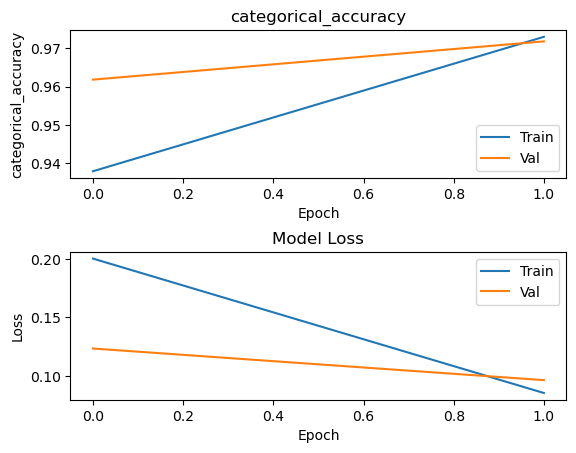

In [123]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=2, batch_size=32, verbose=0, validation_data=(x_val, y_val))
plot_history(history, 'categorical_accuracy')


We can compare the performance of several models by using the defined `x_val` and `y_val` variables. When we are happy with the performance in the validation split, we then evaluate the model in the unseen test data. Let's check if the accuracy in the test set is similar to the accuracy in the validation set in this case.

In [119]:
print('Accuracy in the validation set is {:.2f}'.format(model.evaluate(x_val, y_val)[-1]))
print('Accuracy in the test set is {:.2f}'.format(model.evaluate(x_test, y_test)[-1]))

375/375 [==============================] - 2s 5ms/step - loss: 0.0937 - categorical_accuracy: 0.9722
Accuracy in the validation set is 0.97
313/313 [==============================] - 2s 5ms/step - loss: 0.0880 - categorical_accuracy: 0.9743
Accuracy in the test set is 0.97


### early stopping callback

We know how to define a validation set and how to use it during the training process. An important step now is how to retrieve the model with the highest validation performance during training. We already mentioned this in the introductory Keras tutorial, but let's explain this again now that we know how to define a validation split. By default, Keras returns the last model after training $N$ epochs. We can instead choose to retrieve the model with the best validation performance by using the [`EarlyStopping`](https://keras.io/callbacks/#earlystopping) callback.

- parameters to this callback
    - min delta: least possible change (mine: underneath it we stop, epsillon y3ny)
    - patience: how many epochs we can wait for them when there is no change 
    - verbose 
    - restore_best_weights: get the best weights 

- we pass the callback to model.fit() in callbacks parameter (it takes list of the callback modules we make)

In [124]:
from keras.callbacks import EarlyStopping

# we import the early stopping call back and tell it to monitor the accuracy of the validation set
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=1, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=4096, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stop]) 


Epoch 1/20
12/12 [==============================] - 5s 331ms/step - loss: 0.0286 - categorical_accuracy: 0.9909 - val_loss: 0.0709 - val_categorical_accuracy: 0.9808
Epoch 2/20
12/12 [==============================] - 3s 287ms/step - loss: 0.0156 - categorical_accuracy: 0.9954 - val_loss: 0.0703 - val_categorical_accuracy: 0.9812
Epoch 3/20
12/12 [==============================] - 3s 290ms/step - loss: 0.0101 - categorical_accuracy: 0.9975 - val_loss: 0.0720 - val_categorical_accuracy: 0.9817
Epoch 4/20
12/12 [==============================] - 4s 297ms/step - loss: 0.0071 - categorical_accuracy: 0.9986 - val_loss: 0.0731 - val_categorical_accuracy: 0.9822
Epoch 5/20
12/12 [==============================] - 4s 298ms/step - loss: 0.0049 - categorical_accuracy: 0.9993 - val_loss: 0.0744 - val_categorical_accuracy: 0.9823
Epoch 6/20
12/12 [==============================] - 4s 296ms/step - loss: 0.0034 - categorical_accuracy: 0.9996 - val_loss: 0.0780 - val_categorical_accuracy: 0.9823


- notice that it stopped after only 6 epochs despite having 20 
- because in the 11th epoch we got 0.9823 validation accuracy (the thing we monitor in the callback) and in the 12 epoch we got the same
- and since we have patience as 1 epoch we stopped immediately after 1 epoch of the same accuracy or lower accuracy than the delta 

We check that the performance of the saved model is the same as the obtained in the best epoch in terms of validation accuracy.
- since we set restore_best_weights to true we get the weights of the epoch that had the highest validation accuracy (the thing we monitored in the call back)

In [125]:
model.evaluate(x_val, y_val)

375/375 [==============================] - 2s 5ms/step - loss: 0.0744 - categorical_accuracy: 0.9823


[0.07444705069065094, 0.9823333621025085]

- some people do not like early stopping (but it really depends on the application) sometimes it is useful and sometimes not 

### learning rate scheduler call back

One of the most important parameters to tweak is the training rate, which controls the update step performed during the backpropagation. Keras provides two callbacks that allow us to modify the learning rate during training. One is `LearningRateScheduler`, which allows us to define a rule to vary the learning rate depending on the epoch. For example, using the `lr_scheduler` function (found [here](https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras)), we can modify the loss function so that every 3 epochs is multiplied by 0.1.

In [6]:
from keras import backend as K

Epoch 1/10
47/47 [==============================] - 5s 86ms/step - loss: 0.5316 - categorical_accuracy: 0.8510 - val_loss: 0.2141 - val_categorical_accuracy: 0.9365 - lr: 0.0010
Epoch 2/10
47/47 [==============================] - 4s 78ms/step - loss: 0.1862 - categorical_accuracy: 0.9461 - val_loss: 0.1502 - val_categorical_accuracy: 0.9582 - lr: 0.0010
Epoch 3/10
47/47 [==============================] - 4s 77ms/step - loss: 0.1225 - categorical_accuracy: 0.9645 - val_loss: 0.1166 - val_categorical_accuracy: 0.9661 - lr: 0.0010
Epoch 4/10
47/47 [==============================] - 4s 82ms/step - loss: 0.0893 - categorical_accuracy: 0.9755 - val_loss: 0.1116 - val_categorical_accuracy: 0.9668 - lr: 1.0000e-04
Epoch 5/10
47/47 [==============================] - 4s 80ms/step - loss: 0.0840 - categorical_accuracy: 0.9773 - val_loss: 0.1086 - val_categorical_accuracy: 0.9682 - lr: 1.0000e-04
Epoch 6/10
47/47 [==============================] - 4s 88ms/step - loss: 0.0804 - categorical_accuracy

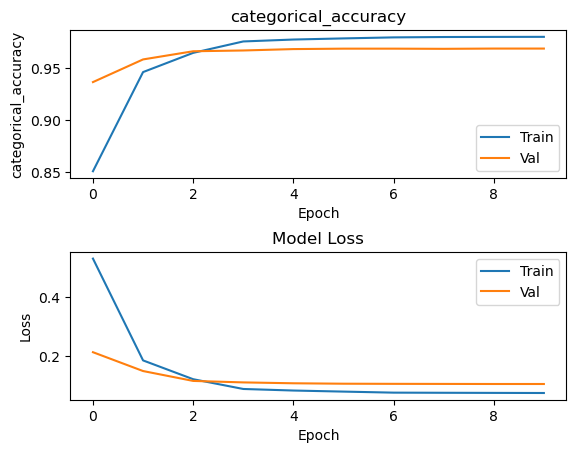

In [7]:
# we define the learning rate scheduler callback's function that will be done after each epoch (since it is a callback)
# this opens our minds for defining our own custom callbacks later 
def lr_scheduler(epoch, lr):
    # new_learning_rate = decay_rate * old_learning_rate,,,, for each decay_step (number of epochs)  
    decay_rate = 0.1
    decay_step = 3 # 3 is a very small number practically, we just put it for illustration purposes 
    if epoch % decay_step == 0 and epoch: # if the number of epoch is multiples of the decay step (3 here) we reduce the learning rate by the specified factor, otherwise return the same lr
        return lr * decay_rate
    return lr

# we pass the above function to the learning rate scheduler callback, then we pass the call back as usual to model.fit()
lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)

model, x_train, y_train, x_test, y_test = get_data_model()

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# get the initial learning rate in the model 
initial_lr = K.get_value(model.optimizer.lr)

history = model.fit(x_train, y_train, epochs=10, batch_size=1024, validation_split=0.2, callbacks=[lrate])
print('Initial Learning Rate: {:.4f}'.format(initial_lr))
print('Final Learning Rate: {:.10f}'.format(K.eval(model.optimizer.lr)))
plot_history(history, 'categorical_accuracy')

- we see above that we started witb 0.001 and we ended up with 0.000001
- since we had 10 epochs and each 3 epochs we reduce by 0.1, then we will reduce it 3 times 

Let's plot the progress of the learning rate in each epoch to check how the learning rate is decreased every three epochs as we defined in `lr_scheduler`.

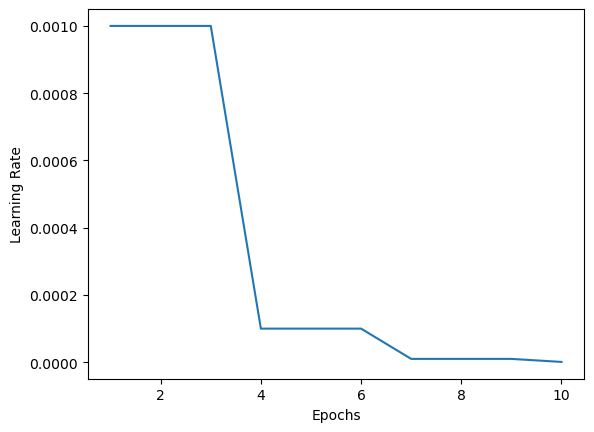

In [8]:
learning_rate = history.history['lr']
plt.plot(range(1, len(learning_rate)+1), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

- notice how the learning rate decreases by 0.1 after each 3 epochs

## reduce learning rate on plateau

- in early stopping we said we monitor something (Accuracy or loss) and if it doesn't get better , it stops the training earlier 
- here is the same but it doesn't stop training, yet decreases the learning rate by a factor 
    - mine:
    - this is useful for examples when we are training and we get to the min or close to it, then the loss and accuracy wouldn't improve much
    - so we reduce the learning rate when this happens 
    - this ensures that we don't skip that minimum (if we kept our learning rate high and had so many epochs)

Another callback provided is `ReduceLROnPlateau`, which reduces the learning rate whenever a given metric has stopped improving. There are 5 important arguments:

 * `monitor`: we specify the metric we want to track
 * `patience`: number of epochs without improvement before reducing lr
 * `factor`: the new learning rate will be `new_lr = lr * factor`
 * `min_lr`: sets the minimum lr (which we can never go below it)
 * `min_delta`: margin to define when the metric has stopped improving (eopslon)
 

In [3]:
from keras import backend as K

Epoch 1/10
12/12 [==============================] - 4s 295ms/step - loss: 1.1705 - categorical_accuracy: 0.6992 - val_loss: 0.3887 - val_categorical_accuracy: 0.8859 - lr: 0.0010
Epoch 2/10
12/12 [==============================] - 4s 345ms/step - loss: 0.3569 - categorical_accuracy: 0.8966 - val_loss: 0.2807 - val_categorical_accuracy: 0.9192 - lr: 0.0010
Epoch 3/10
12/12 [==============================] - 3s 258ms/step - loss: 0.2625 - categorical_accuracy: 0.9238 - val_loss: 0.2305 - val_categorical_accuracy: 0.9336 - lr: 0.0010
Epoch 4/10
12/12 [==============================] - 3s 250ms/step - loss: 0.2085 - categorical_accuracy: 0.9396 - val_loss: 0.1860 - val_categorical_accuracy: 0.9457 - lr: 0.0010
Epoch 5/10
12/12 [==============================] - 3s 270ms/step - loss: 0.1708 - categorical_accuracy: 0.9509 - val_loss: 0.1653 - val_categorical_accuracy: 0.9541 - lr: 0.0010
Epoch 6/10
12/12 [==============================] - 3s 258ms/step - loss: 0.1467 - categorical_accuracy: 

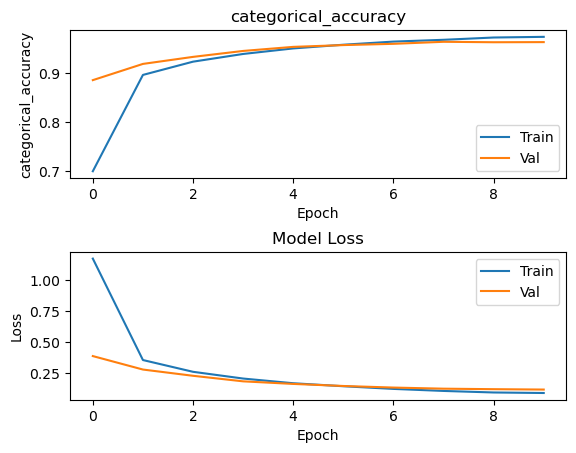

In [4]:
from keras.callbacks import ReduceLROnPlateau
# here we say monitor the validation loss and if it doesn't change (get reduced by) more than 0.01, and after waiting 1 extra epoch, then reduce the learning rate by multiplying with 0.2 and never go below 0.00001 
# notice that the min_lr is so small already -if we got to it then it will probably be so slow that the GD won't learn anything (would take infinitissimly small steps)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00001, min_delta = 0.01)

model, x_train, y_train, x_test, y_test = get_data_model() 
# notice that we optimize the loss, monitor the accuracy in metrics, and monitor the validation loss in reducing the lr 
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

initial_lr = K.get_value(model.optimizer.lr)

# by increasing the batch size we get closer to batch GD (faster results because we do less parameter updates) but we consume more memory
history = model.fit(x_train, y_train, epochs=10, batch_size=4096, validation_split=0.2, callbacks=[reduce_lr])

print('Initial Learning Rate: {:.4f}'.format(initial_lr))
print('Final Learning Rate: {:.10f}'.format(K.eval(model.optimizer.lr)))
plot_history(history, 'categorical_accuracy')

notice that at epoch 9 (which is the first -1- epoch that doesn't lower the loss by more than 0.01, we decreased the learning rate

Again, we check how the learning rate has changed. You can check that the learning has indeed decreased when the `val_loss` has not improved by more than 0.01 until it reached the `min_lr` value.

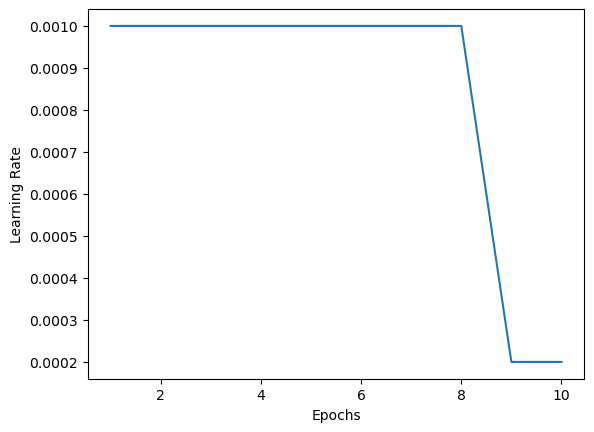

In [6]:
learning_rate = history.history['lr']
plt.plot(range(1, len(learning_rate)+1), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

- practically, nowadays people use what's called **warm-up learning rate** as we start with low learning rate that increases (warming up) then we decrease it with smooth decay as shown below 
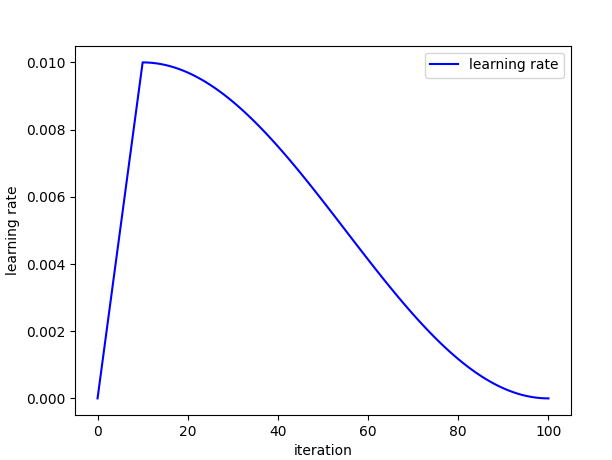
- this is used with bigger NNs with big data sizes

### Searching for the right set of parameters

Apart from the learning rate, there are several hyperparameters we can tune: the optimizer parameters (momentum, beta, rho, decay), the dropout rate, the number of neurons/feature maps, batch size, regularization weights, etc...  After some time working with the models, you gain an intuition of what set of parameters work better. However, performing a proper search of hyperparameters may improve the results. A way to do this (among several others) is performing a search of parameters. Several available packages can help you with hyperparameter optimization in Keras, the one we will use is called [`talos`](https://github.com/autonomio/talos).

- we want to **automate hyperparameter tuning** 
    - we may use **grid search** 
        - we may do it **manually**
        - or using a library called **talos**

In [15]:
# this executed in the terminal -not the python kernel here- since we used !
!pip install talos==0.4.9 --user

In [20]:
!python -m pip install talos==0.4.9

**make sure to restart the kernel afterwards**

Now we show a quick example of how to do it. We set only 2 epoch of training and `grid_downsampling=0.05`, which controls the number of sets of hyperparameters tested.

- we give it the pararmeters we want to grid search on and it does so

In [5]:
from tensorflow.keras.layers import Dropout

In [6]:
import talos as ta
_, x_train, y_train, x_test, y_test = get_data_model() # we got the data 

# we define a function and pass it to talos so that it search in it
def model_scan(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  model.add(Dense(params['first_neuron'], input_shape=(784,), activation=params['activation']))
  model.add(Dropout(params['dropout']))
  model.add(Dense(10, activation=params['last_activation']))

  model.compile(optimizer=params['optimizer'](lr = params['lr']),
                loss=params['losses'],
                metrics=['categorical_accuracy'])
  
  out = model.fit(x_train, y_train,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  verbose=0,
                  validation_data=[x_val, y_val])
  
  return out, model # out here is the history

# this dictionary is similar to **args we saw earlier 
p = {}
p['lr'] = [0.0001, 0.001]
p['first_neuron'] = [8, 16, 32, 64, 128]
p['batch_size'] =  [1024, 2048]
p['epochs'] =  [2]
p['dropout'] =  [0, 0.40, 0.7]
p['weight_regularizer'] = [None]
p['optimizer'] =  [keras.optimizers.Adam, keras.optimizers.SGD]
p['losses'] =  ['categorical_crossentropy']
p['activation'] = ['relu', 'tanh']
p['last_activation'] =  ['softmax']
## grid_downsample limits the number of combinations run in the search
## to the fraction set (e.g. 0.05 runs 5% of the possible combinations) 
h = ta.Scan(x_train, y_train,
          params=p,
          model=model_scan, # the function of training 
          grid_downsample=0.05,
          print_params=True,
          disable_progress_bar=True) # not so important

{'lr': 0.0001, 'first_neuron': 32, 'batch_size': 1024, 'epochs': 2, 'dropout': 0, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'tanh', 'last_activation': 'softmax'}
{'lr': 0.0001, 'first_neuron': 64, 'batch_size': 2048, 'epochs': 2, 'dropout': 0, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'tanh', 'last_activation': 'softmax'}
{'lr': 0.001, 'first_neuron': 128, 'batch_size': 2048, 'epochs': 2, 'dropout': 0.4, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax'}
{'lr': 0.001, 'first_neuron': 128, 'batch_size': 1024, 'epochs': 2, 'dropout': 0.4, 'weight_regularizer': None, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, 'losses': 'categori

**practically**
- we rarely use talos, in fact we rarely use the idea of gridsearch itself or hyperparameter tuning
- that is because we have small model with small data sizes here 
- but we usually work on big models later with huge data, therefore we don't have the luxury to use and apply gridsearch 

**what do we do?**
- we tune the hyper parameters based on our **intuition** :)
- as gridsearch seems like a bruteforce solution that requires no intuition
- and if the model has a problem we wait then choose a better model

Now we check the results of the experiment.

In [7]:
from talos import Reporting
r = Reporting(h)
# returns the results dataframe
r.data

,round_epochs,loss,categorical_accuracy,val_loss,val_categorical_accuracy,lr,first_neuron,batch_size,epochs,dropout,weight_regularizer,optimizer,losses,activation,last_activation
0,2,1.904021,0.454024,1.755705,0.563056,0.0001,32,1024,2,0.0,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,tanh,softmax
1,2,2.036067,0.344214,1.909348,0.432556,0.0001,64,2048,2,0.0,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,tanh,softmax
2,2,0.656131,0.808381,0.438745,0.880611,0.0010,128,2048,2,0.4,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,relu,softmax
3,2,2.391496,0.108881,2.319440,0.129500,0.0010,128,1024,2,0.4,None,<class 'keras.optimizers.optimizer_v2.gradient...,categorical_crossentropy,relu,softmax
4,2,0.484089,0.860524,0.338327,0.907444,0.0010,128,1024,2,0.4,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,relu,softmax
5,2,2.047622,0.270881,1.868815,0.419889,0.0001,64,2048,2,0.4,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,tanh,softmax
6,2,2.577568,0.092476,2.506128,0.096556,0.0001,128,1024,2,0.4,None,<class 'keras.optimizers.optimizer_v2.gradient...,categorical_crossentropy,relu,softmax
7,2,2.305136,0.114452,2.267848,0.155889,0.0001,8,2048,2,0.7,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,relu,softmax
8,2,1.413655,0.690476,1.286419,0.725389,0.0010,8,1024,2,0.0,None,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,categorical_crossentropy,tanh,softmax
9,2,2.342343,0.096714,2.316707,0.105500,0.0010,8,2048,2,0.4,None,<class 'keras.optimizers.optimizer_v2.gradient...,categorical_crossentropy,relu,softmax


- general tips 
    - when we **increase the batch size**, we get closer to the batch gradient descent therefore, the updates happen after alot of examples, therefore **we eventually end up with better scores** 

- mine: notice that talos didn't run all the possible combinations, but chose some of them in a smart way
- there is a function that gets the best parameters,check the documentation for more 

[Talos' documentation](https://autonomio.github.io/docs_talos/#introduction) provides more information about the package.

## Data augmentation
Deep learning models are data-hungry, tend to overfit with small training sets and its performance benefit from large training sets. A way to synthetically create more data is using data augmentation. Now, we will show some examples of data augmentation for images.
### Images
Data augmentation techniques such as rotation, color jittering, scale or cropping are usually applied in deep learning pipelines for vision applications. The idea is to take as input an image, apply a transformation to it, and then use it for training.

Keras includes a preprocessing module, with all [these transformations](https://keras.io/preprocessing/image/) implemented. The preprocessing module can be imported by doing




In [1]:
from keras.preprocessing.image import ImageDataGenerator

Then we need to fit it to the input data using `fit` (which computes statistics from the dataset, such as means and std values) and use `flow` to apply the transformations to the input data. In the function `plot_data_augmentation` defined in the code cell below we can see the process of fitting the data and then using flow to iterate over the generator.



In [3]:
# this function applies the transformation then plots some samples of the result
def plot_data_augmentation(augmentation_gen = ImageDataGenerator()):
  # we get the data 
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  
  # we fit the xtrain to the function generator after expanding its dimension (to be suitable to the function)
  augmentation_gen.fit(np.expand_dims(x_train, -1))
   
  # we apply the augmentation using .flow() on 5 images by 5 images and so on and we loop on the result to plot them
  for X_batch, y_batch in augmentation_gen.flow(np.expand_dims(x_train, -1), y_train, batch_size=5, shuffle=False):
    print(X_batch.shape,y_batch.shape)
    # loop on the 5 images that we get each outer loop
    for i in range(0, 5):
      plt.subplot(150 + 1 + i)
      plt.imshow(X_batch[i, :].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    # this executes only 1 round of the outer loops (plots the first batch of 5 examples only) 
    break

In [4]:
np.expand_dims(x_train, -1).shape

(60000, 784, 1)

In [5]:
x_train.shape

(60000, 784)

We will now visualize some of the transformations available to use.

First, we plot some images without any transformations applied for comparison.

(5, 28, 28, 1) (5,)


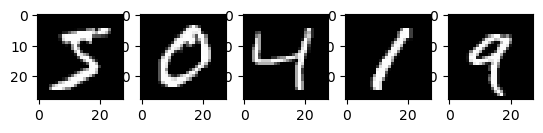

(5, 28, 28, 1) (5,)


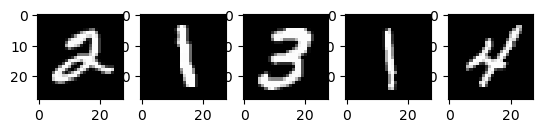

(5, 28, 28, 1) (5,)


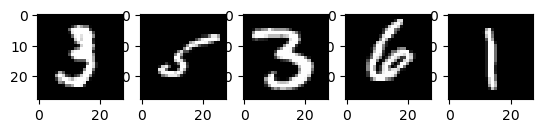

(5, 28, 28, 1) (5,)


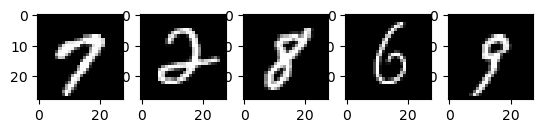

(5, 28, 28, 1) (5,)


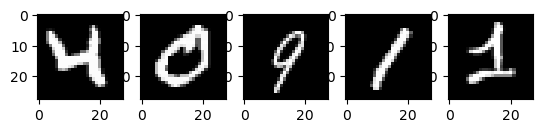

(5, 28, 28, 1) (5,)


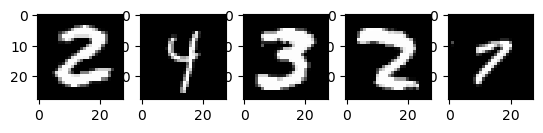

(5, 28, 28, 1) (5,)


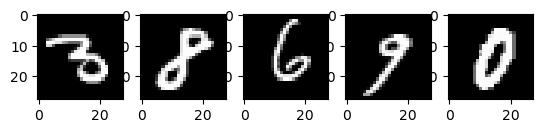

(5, 28, 28, 1) (5,)


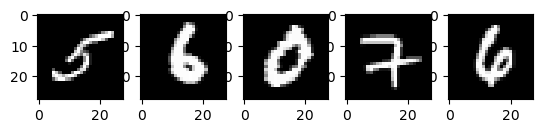

(5, 28, 28, 1) (5,)


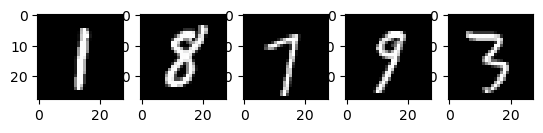

(5, 28, 28, 1) (5,)


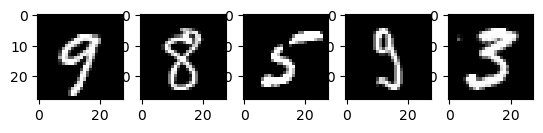

(5, 28, 28, 1) (5,)


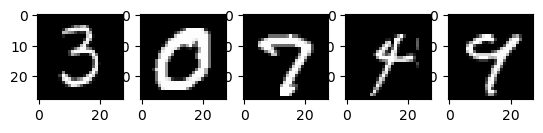

(5, 28, 28, 1) (5,)


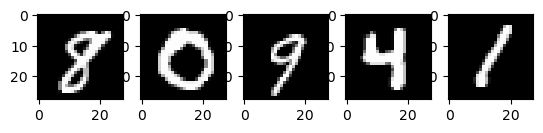

(5, 28, 28, 1) (5,)


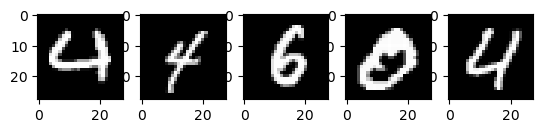

(5, 28, 28, 1) (5,)


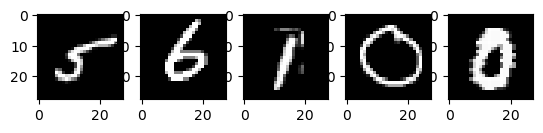

(5, 28, 28, 1) (5,)


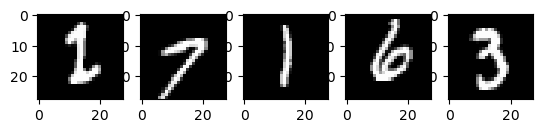

(5, 28, 28, 1) (5,)


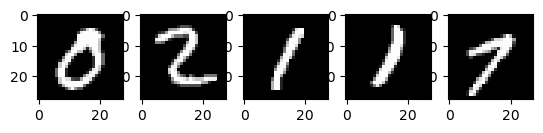

(5, 28, 28, 1) (5,)


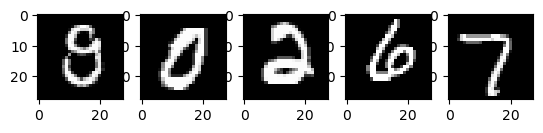

(5, 28, 28, 1) (5,)


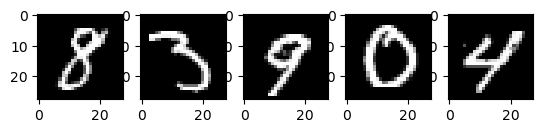

(5, 28, 28, 1) (5,)


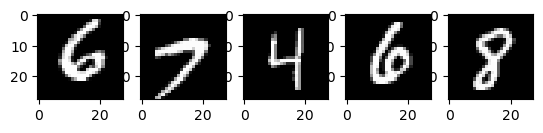

(5, 28, 28, 1) (5,)


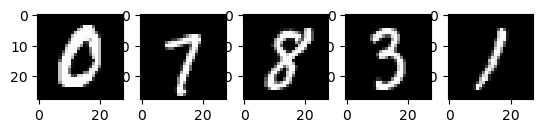

(5, 28, 28, 1) (5,)


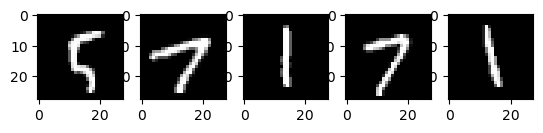

(5, 28, 28, 1) (5,)


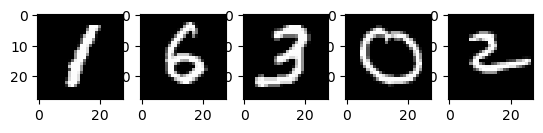

(5, 28, 28, 1) (5,)


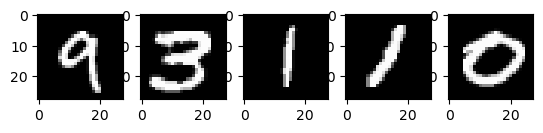

(5, 28, 28, 1) (5,)


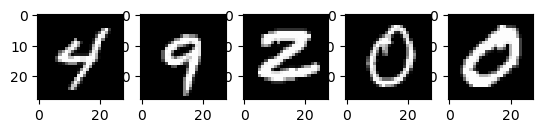

(5, 28, 28, 1) (5,)


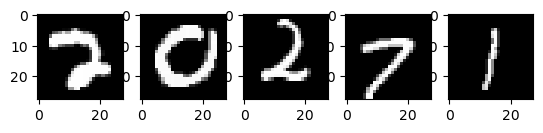

(5, 28, 28, 1) (5,)


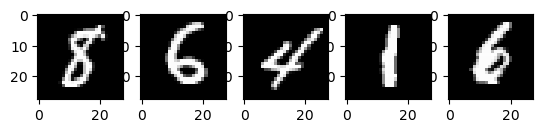

(5, 28, 28, 1) (5,)


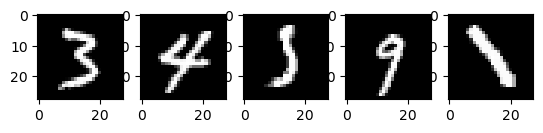

(5, 28, 28, 1) (5,)


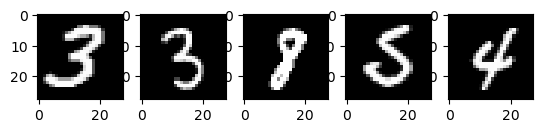

(5, 28, 28, 1) (5,)


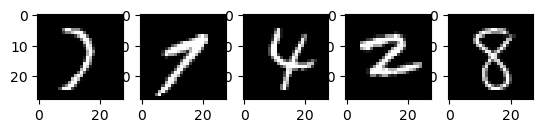

(5, 28, 28, 1) (5,)


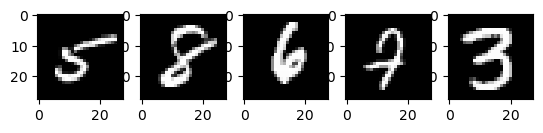

(5, 28, 28, 1) (5,)


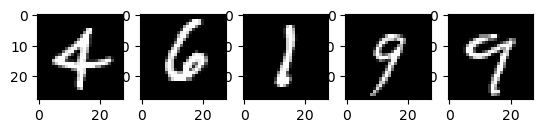

(5, 28, 28, 1) (5,)


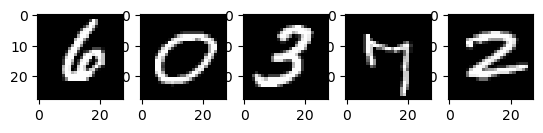

(5, 28, 28, 1) (5,)


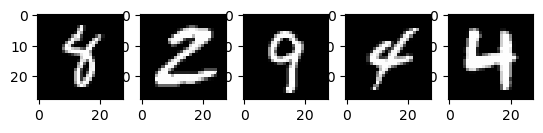

(5, 28, 28, 1) (5,)


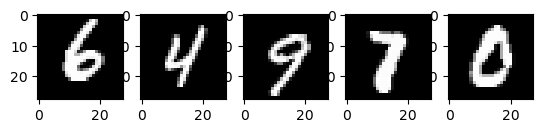

(5, 28, 28, 1) (5,)


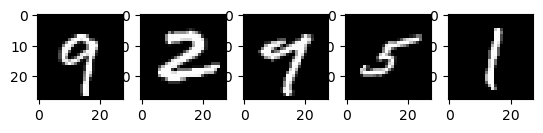

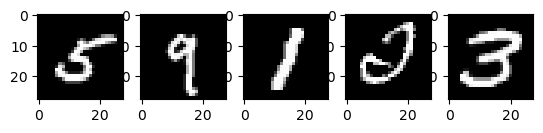

(5, 28, 28, 1) (5,)


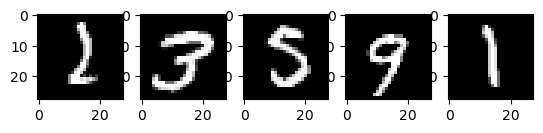

(5, 28, 28, 1) (5,)


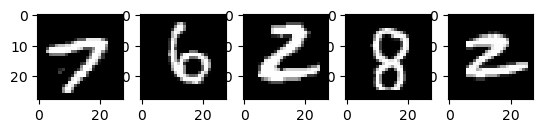

(5, 28, 28, 1) (5,)


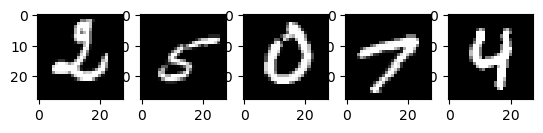

(5, 28, 28, 1) (5,)


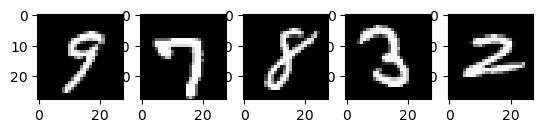

(5, 28, 28, 1) (5,)


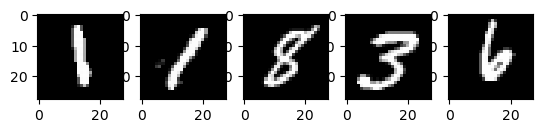

(5, 28, 28, 1) (5,)


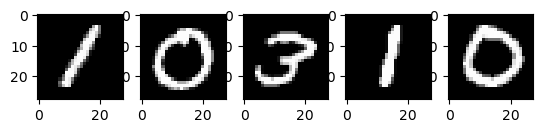

(5, 28, 28, 1) (5,)


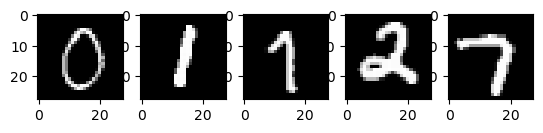

(5, 28, 28, 1) (5,)


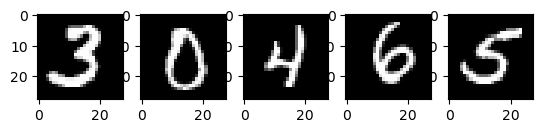

(5, 28, 28, 1) (5,)


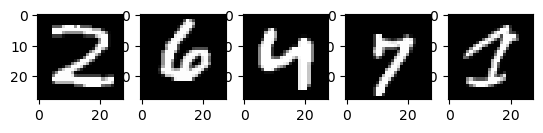

(5, 28, 28, 1) (5,)


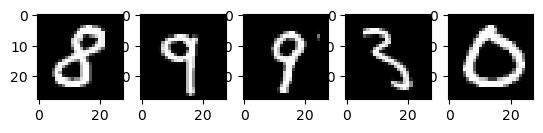

(5, 28, 28, 1) (5,)


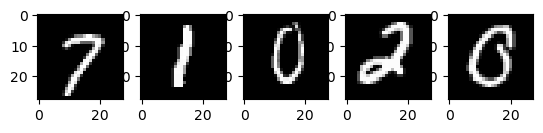

(5, 28, 28, 1) (5,)


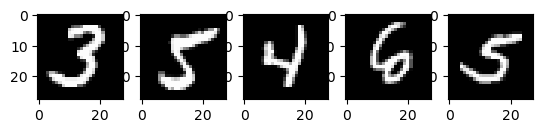

(5, 28, 28, 1) (5,)


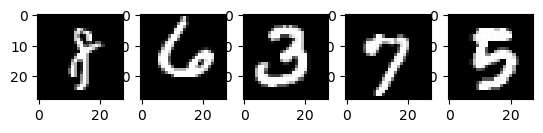

(5, 28, 28, 1) (5,)


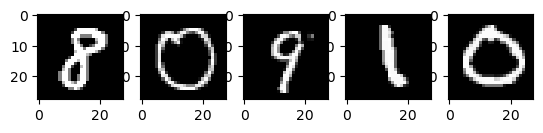

(5, 28, 28, 1) (5,)


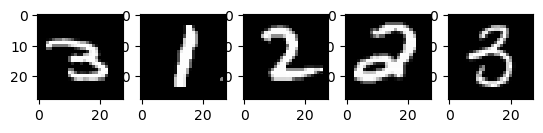

(5, 28, 28, 1) (5,)


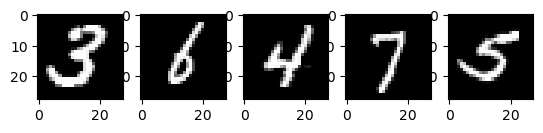

(5, 28, 28, 1) (5,)


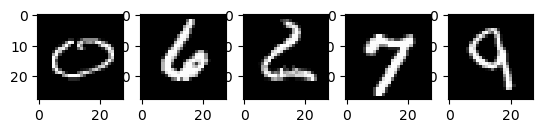

(5, 28, 28, 1) (5,)


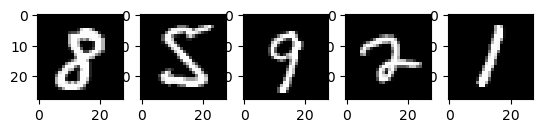

(5, 28, 28, 1) (5,)


In [ ]:
# will plot the same input because we haven't specified any parameters to the generator
plot_data_augmentation()

### Rotation
A standard transformation is to rotate the image. We can do so by initializing ImageDataGenerator with `rotation_range=rot_val`.

- rotates the image within the range of 0-90 degrees to the left or right,
- and practically, 90 degrees rotation is **too large**, people don't do that in most applications 
    - because in test we wouldn't find for example an image rotated by 90 degrees (it's not representative to the test set)
    - a more realistic values for rotation would be 0-30 degree
    - see the result and check for yourself what angle might be representative to the test cases

(5, 28, 28, 1) (5,)


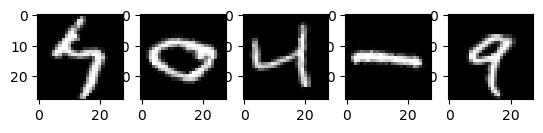

In [20]:
# We first define the transformation we want to apply
augmentation_gen = ImageDataGenerator(rotation_range=90)
plot_data_augmentation(augmentation_gen)

### Shift

We can define a maximum range of both horizontal (`width_shift_range`) and vertical (`height_shift_range`) shift.
- it shifts the images with random values horizontally and vertically but constrained with the maximum we specify

(5, 28, 28, 1) (5,)


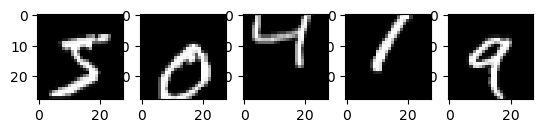

In [25]:
# 0.3 here means shift the image horizontally 30% of the width and vertically 30% of the height 
augmentation_gen = ImageDataGenerator(width_shift_range=0.7)
plot_data_augmentation(augmentation_gen)

(5, 28, 28, 1) (5,)


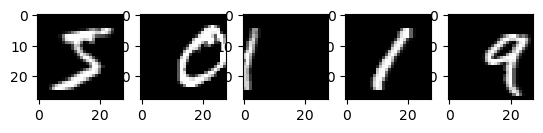

In [26]:
augmentation_gen = ImageDataGenerator(height_shift_range=0.7)
plot_data_augmentation(augmentation_gen)

- notice that they shifted with random amounts and random directions but constrined with the maximum values we specified 

### Zooming
Zooming into the image can be done with `zoom_range`.
- zooms in and out with a range of percentage of the image size

(5, 28, 28, 1) (5,)


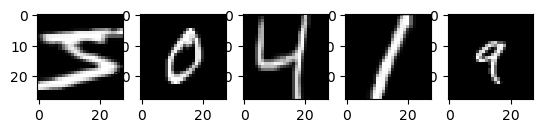

In [33]:
# zooms in and out with a range of 40% of the image size 
augmentation_gen = ImageDataGenerator(zoom_range=0.5)
plot_data_augmentation(augmentation_gen)

### Flip

We can define either horizontal flip (`horizontal_flip`) or vertical (`vertical_flip`).  
- it depends on the application (we see wither we might have images that are flipped horizontally or vertically 
    - like train a cat looking to the right and to the left 

(5, 28, 28, 1) (5,)


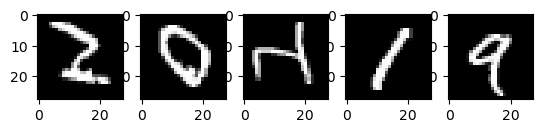

In [36]:
augmentation_gen = ImageDataGenerator(horizontal_flip=False, vertical_flip=True)
plot_data_augmentation(augmentation_gen)

(5, 28, 28, 1) (5,)


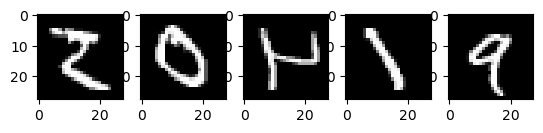

In [39]:
augmentation_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=False)
plot_data_augmentation(augmentation_gen)

### Combining transformations
We can combine all the transformations and train a model. The `ImageDataGenerator` is a generator, so we need to use the method `fit_generator`, which is explained [in the documentation](https://keras.io/models/sequential/).

In [43]:
augmentation_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# load the data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# fit the data to the generator after expanding the dimensions 
augmentation_gen.fit(np.expand_dims(x_train, -1))
# get the new augmented data after appplyig the flow on the expanded original data (we get few augemented data and their labels) 
train_gen = augmentation_gen.flow(np.expand_dims(x_train, -1), keras.utils.to_categorical(y_train))

# define the model and train it 
model = Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# we called model.fit_generator() because now it takes a generator and not a training set
model.fit_generator(train_gen, steps_per_epoch=len(x_train), epochs=10)

Epoch 1/10


C:\Users\youse\AppData\Local\Temp\ipykernel_16108\1259465637.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, steps_per_epoch=len(x_train), epochs=10)


60000/60000 [==============================] - 63s 1ms/step - loss: 1.0769 - categorical_accuracy: 0.6348


In [46]:
train_gen.batch_size

32

In [42]:
x_train.shape

(60000, 28, 28)

it is done, mine: notice that we trained on train_gen which is of size 32 (we just want to ensure it took all the classes)  

In these examples we showed practical examples of data augmentation for images. However, other modalities, such as text or audio can also benefit from data augmentation as shown in the lecture slides.

In [55]:
# more on generators 
# this is a function that takes a list, and we want to return element from it each time we call it
def foo(x):
    i = 0
    for i in x:
        return x[i]

In [58]:
x = [x for x in range(10)]
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [59]:
foo(x)

0

In [60]:
foo(x)

0

- notice that each time we call it, we always get the first result only (because of return)
- python has something else called **yield**

In [61]:
# more on generators 
# this is a function that takes a list, and we want to return element from it each time we call it
def foo(x):
    i = 0
    for i in x:
        yield x[i]

In [65]:
t = foo(x)
type(t)

generator

- now each time we call it we get an encapsulator to a different value 
- we use it to divide the returns to batches (the data itself to batches) and each time we call it we get different returns  
- mine: so above we should keep on getting more generators and fitting the model on them or getting all of the augmented data at once somehow 

## Tensorboard (a module to visualize)
Tensorboard is quite useful to monitor the different metrics in real time. Both Tensorflow and Pytorch users (using the TensorboardX module) can use it. Tensorboard can be used in Keras by using the Tensorboard callback available ([documentation here](https://keras.io/callbacks/)).

However, to make it working in a Colab environment, we need to follow a different process, which is explained [here](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6). When you run the following piece of code, a Tensorboard link will be displayed. If you click on it, and you will be redirected to the Tensorboard site.

- it can be used to do alot of things
    - keeps tracks of the logs 
    - visualize images 
    - visualize samples from test set 
    - visualize audio or video 
    
    
- **weights and biases** are more advanced than tensorBoard

In [48]:
!pip install tensorboardcolab
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

In [47]:
!pip install tensorboard

In [51]:
import tensorboard
import keras.backend as K

K.clear_session()

# we initanciate a tensor board with the dirctory of logs (in which the logs will be placed)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# this is the code in tensor board 

#import tensorboardcolab as tbc
#tboard = tbc.TensorBoardColab()
#from tensorboardcolab import TensorBoardColabCallback

Now, we can use a callback function to show the training progress in the given link. 

In [52]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy')
# we train and pass the callback as usual
model.fit(x_train, y_train, epochs=30, batch_size=8192,  validation_split=0.2, callbacks=[tbCallBack])

Epoch 1/30
6/6 [==============================] - 5s 740ms/step - loss: 1.6138 - val_loss: 0.7455
Epoch 2/30
6/6 [==============================] - 4s 658ms/step - loss: 0.5655 - val_loss: 0.3667
Epoch 3/30
6/6 [==============================] - 5s 765ms/step - loss: 0.3657 - val_loss: 0.3142
Epoch 4/30
6/6 [==============================] - 4s 733ms/step - loss: 0.3098 - val_loss: 0.2689
Epoch 5/30
6/6 [==============================] - 4s 624ms/step - loss: 0.2679 - val_loss: 0.2371
Epoch 6/30
6/6 [==============================] - 4s 626ms/step - loss: 0.2338 - val_loss: 0.2093
Epoch 7/30
6/6 [==============================] - 4s 737ms/step - loss: 0.2072 - val_loss: 0.1902
Epoch 8/30
6/6 [==============================] - 4s 635ms/step - loss: 0.1857 - val_loss: 0.1758
Epoch 9/30
6/6 [==============================] - 4s 647ms/step - loss: 0.1673 - val_loss: 0.1642
Epoch 10/30
6/6 [==============================] - 4s 659ms/step - loss: 0.1516 - val_loss: 0.1539
Epoch 11/30
6/6 [==

In the Tensorboard website you should see two sections: *Scalars* and *Graph*. In *Scalars* there is the plot with the training and validation loss per epoch, and in *Graph* you should have the graph of your model. You can also plot images, histograms, distributions and other things in Tensorboard, which makes it quite useful to keep track of the training progress. You will not have to use Tensorboard for the tutorials, however it is a nice visualization tool that can be useful for future projects.

## Exercise
You will use the Wine Quality (http://archive.ics.uci.edu/ml/datasets/Wine+Quality) dataset. Use only the red wine data. The goal is to find the quality score of some wine based on its attributes. Write your code in a script neural_net.py. 

1)	First, download the winequality-red.csv file, load it, and divide the data into a training and test set using approximately 50% for training. Standardize the data, by computing the mean and standard deviation for each feature dimension using the training set only, then subtracting the mean and dividing by the stdev for each feature and each sample. Append a 1 for each feature vector, which will correspond to the bias that our model learns. Set the number of hidden units, the number of iterations to run, and the learning rate. 
2)	Call the backward function to construct and train the network. Use 1000 iterations and 30 hidden neurons. 
3)	Then call the forward function to make predictions and compute the root mean squared error between predicted and ground-truth labels. Report this number in a file lab3.pdf/docx 
4)	Experiment with three different values of the learning rate. For each, plot the error over time (output by backward above). Include these plots in your report.
